In [1]:
%matplotlib inline
from StringProcessing import StringProcessing
from BuildVocabulary import BuildVocabulary as bv
from TransformerEncoder import TransformerEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from nltk.tokenize.toktok import ToktokTokenizer
from Visualization import Visualization
from gensim.models import Word2Vec
from Preprocess import Preprocess
from Utils import Utils
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Parameters

In [2]:
# Text parameters #
max_words = 50
test_path = "./tass-corpus/es/dev.csv" # Dev

# Training Parameters #
path_model = "./best-models/transformer_es.hdf5"
r_cats = {0:"N", 1:"NEU", 2:"NONE", 3:"P"}
tokenizer = ToktokTokenizer()
w2v_path = "./twitter87/twitter87.model"
w2v = Word2Vec.load(w2v_path)

# Encoder Parameters # # MEJOR
dropout_input = 0.7 #0.7
dropout_output = 0. # 0.
pe = False #False
embedding_dims = w2v.vector_size
n_encoders = 1 #2 #1
attention_dims = 64 #32 #64
n_heads = 8 #8
dim_h = 128 #256
final_h = False #False
pool_mode = "average" #"average"

output_encoder_dims = [embedding_dims for i in range(n_encoders)]
attention_dims = [attention_dims for i in range(n_encoders)]
n_heads = [n_heads for i in range(n_encoders)]

# Prepare inputs #

In [3]:
ids_dv, x_dv, y_dv = StringProcessing.load_samples(test_path)

# Preprocess #
x_dv = [Preprocess.preprocess(x, tokenizer) for x in x_dv]

# Represent #
rx_dv = np.array(StringProcessing.represent_documents(x_dv, max_words, embedding_dims, w2v, word_delimiter = " "))

# Masks #
masks_dv = np.array([((rx!=0).sum(axis=1)>0).astype("int") for rx in rx_dv])

# Positional Encodings #
matrix_pos_encodings = Utils.precompute_sent_pos_encodings(max_words, embedding_dims)
pe_dv = np.array([Utils.build_pe_sent_encodings(matrix_pos_encodings, m) for m in masks_dv])

# Load model

In [4]:
ht = TransformerEncoder(max_words = max_words,
                 embedding_dims = embedding_dims,
                 output_encoder_dims = output_encoder_dims,
                 attention_dims = attention_dims,
                 n_heads = n_heads,
                 dropout_input = dropout_input,
                 dropout_output = dropout_output,
                 pe = pe,
                 dim_h = dim_h,
                 final_h = final_h,
                 pool_mode = pool_mode)

ht.build()
print(ht.model.summary())
ht.compile(ht.model)
ht.load(ht.model, path_model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
my_masking_1 (MyMasking)        (None, 50, 300)      0           input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 300)      0           my_masking_1[0][0]               
__________________________________________________________________________________________________
sentence_encoder_bloc

# Predict

In [5]:
preds = ht.model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)
preds = [r_cats[p.argmax()] for p in preds]
truths = y_dv
print("Acc: %f" % accuracy_score(truths, preds))
print("MF1: %f" % f1_score(truths, preds, average="macro"))
print("MP: %f" % precision_score(truths, preds, average="macro"))
print("MR: %f" % recall_score(truths, preds, average="macro"))
print("Conf Matrix\n", confusion_matrix(truths, preds))
print("Classification Report\n", classification_report(truths, preds))

Acc: 0.607573
MF1: 0.533422
MP: 0.527952
MR: 0.543807
Conf Matrix
 [[195  25  18  28]
 [ 25  22  13  23]
 [  9   6  38  11]
 [ 38  19  13  98]]
Classification Report
               precision    recall  f1-score   support

           N       0.73      0.73      0.73       266
         NEU       0.31      0.27      0.28        83
        NONE       0.46      0.59      0.52        64
           P       0.61      0.58      0.60       168

   micro avg       0.61      0.61      0.61       581
   macro avg       0.53      0.54      0.53       581
weighted avg       0.61      0.61      0.61       581



# Save Prediction Report

In [6]:
# Guarda un csv (texto, real, prediccion)
fw = open("results_report.csv", "w", encoding="utf8")
for i in range(len(preds)):
    fw.write(x_dv[i] + "\t" + truths[i] + "\t" + preds[i] + "\n")
fw.close()

# Get Attention Report

In [7]:
attns = ht.attn_model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)

## Preds

In [8]:
# Palabra : {cabezal : {P:0, N:0, NEU:}}
word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = preds[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}
                counters[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}

            word_attns[word][h][pred] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h][pred] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        for c in word_attns[w][h]:
            word_attns[w][h][c] /= (counters[w][h][c] + 1e-16) #len(x_dv)      

In [9]:
word_attns["mierda"]

{0: {'N': 0.19932349895245377,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.4469071328639984},
 1: {'N': 0.5376216207421015,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.016574546694755554},
 2: {'N': 0.000777379267428937,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.0028707406017929316},
 3: {'N': 0.8665121072436136,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.9754916429519653},
 4: {'N': 0.0011118251828999733,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 8.177208655979484e-05},
 5: {'N': 0.23908702309169466,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.24075926840305328},
 6: {'N': 0.5945630950019474,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.19072802364826202},
 7: {'N': 0.0004926495491466966,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.002123745623975992}}

## Truths

In [10]:
# Palabra : {cabezal : {P:0, N:0, NEU:}}
word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}
                counters[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}

            word_attns[word][h][pred] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h][pred] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        for c in word_attns[w][h]:
            word_attns[w][h][c] /= (counters[w][h][c] + 1e-16) #len(x_dv) 

In [11]:
word_attns["mierda"]

{0: {'N': 0.24908238081409342,
  'NEU': 0.4469071328639984,
  'NONE': 0.0,
  'P': 0.000287971505895257},
 1: {'N': 0.49952286313923583,
  'NEU': 0.016574546694755554,
  'NONE': 0.0,
  'P': 0.6900166511535645},
 2: {'N': 0.0009717239728493115,
  'NEU': 0.0028707406017929316,
  'NONE': 0.0,
  'P': 4.4574743895964275e-10},
 3: {'N': 0.8798592798293583,
  'NEU': 0.9754916429519653,
  'NONE': 0.0,
  'P': 0.8131234169006347},
 4: {'N': 0.0006660720331782368,
  'NEU': 8.177208655979484e-05,
  'NONE': 0.0,
  'P': 0.0028948377817869186},
 5: {'N': 0.2123220554892979,
  'NEU': 0.24075926840305328,
  'NONE': 0.0,
  'P': 0.34614689350128175},
 6: {'N': 0.6236615561303639,
  'NEU': 0.19072802364826202,
  'NONE': 0.0,
  'P': 0.47816925048828124},
 7: {'N': 0.0006132157668905584,
  'NEU': 0.002123745623975992,
  'NONE': 0.0,
  'P': 1.0384678171249107e-05}}

## All classes (creo que este es el análisis bueno, más que por cada clase)

In [12]:
# Palabra : {cabezal : }

word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = 0.
                counters[word][h] = 0.

            word_attns[word][h] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        word_attns[w][h] /= (counters[w][h] + 1e-16) #len(x_dv) 

In [13]:
list(word_attns["mierda"].values())

[0.24058743793771123,
 0.4507804417342105,
 0.0011262728231562693,
 0.8846753631950056,
 0.0009401496668432768,
 0.23936573064358777,
 0.5272572497763331,
 0.0007644988949515792]

<BarContainer object of 8 artists>

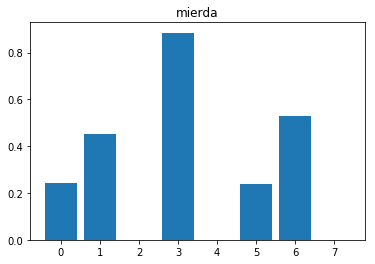

In [14]:
w = "mierda"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

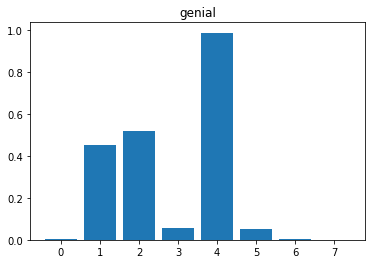

In [15]:
w = "genial"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

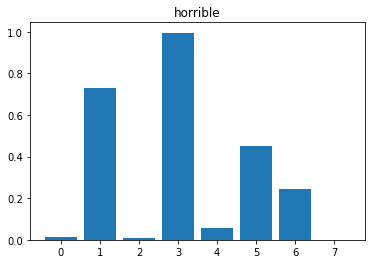

In [16]:
w = "horrible"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

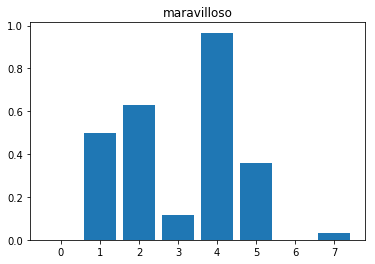

In [17]:
w = "maravilloso"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

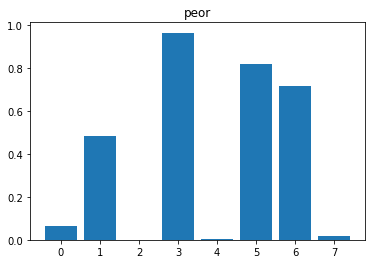

In [18]:
w = "peor"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

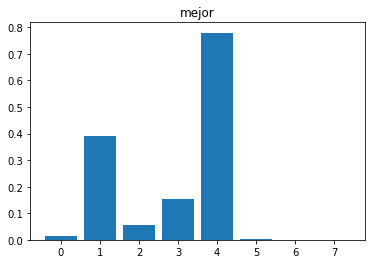

In [19]:
w = "mejor"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

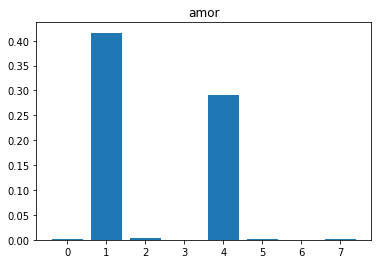

In [20]:
w = "amor"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

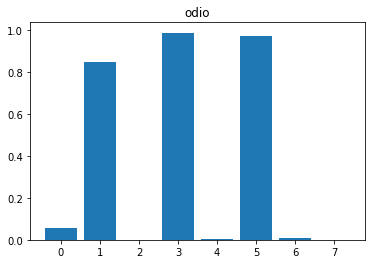

In [21]:
w = "odio"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

Parece que el cabezal 3 reacciona mucho con palabras negativas y poco a las positivas; y el cabezal 4 justo al contrario

# Attns Visualization

In [22]:
n = 40 # 46 (PE), 40 (ES)
attns_i = attns[n]
l_words = x_dv[n].split()

pad = 0
while len(l_words) < max_words:
    l_words.insert(0, "<pad>")
    pad += 1
l_words = l_words[pad:]
attns_i = attns_i[:, pad:, pad:]
attns_h_3 = attns_i[3]
attns_h_4 = attns_i[4]

In [23]:
print(x_dv[n])

odio a lucia la vd , mi amor hacia ella es una gran tapadera pa comer nutella en su casa


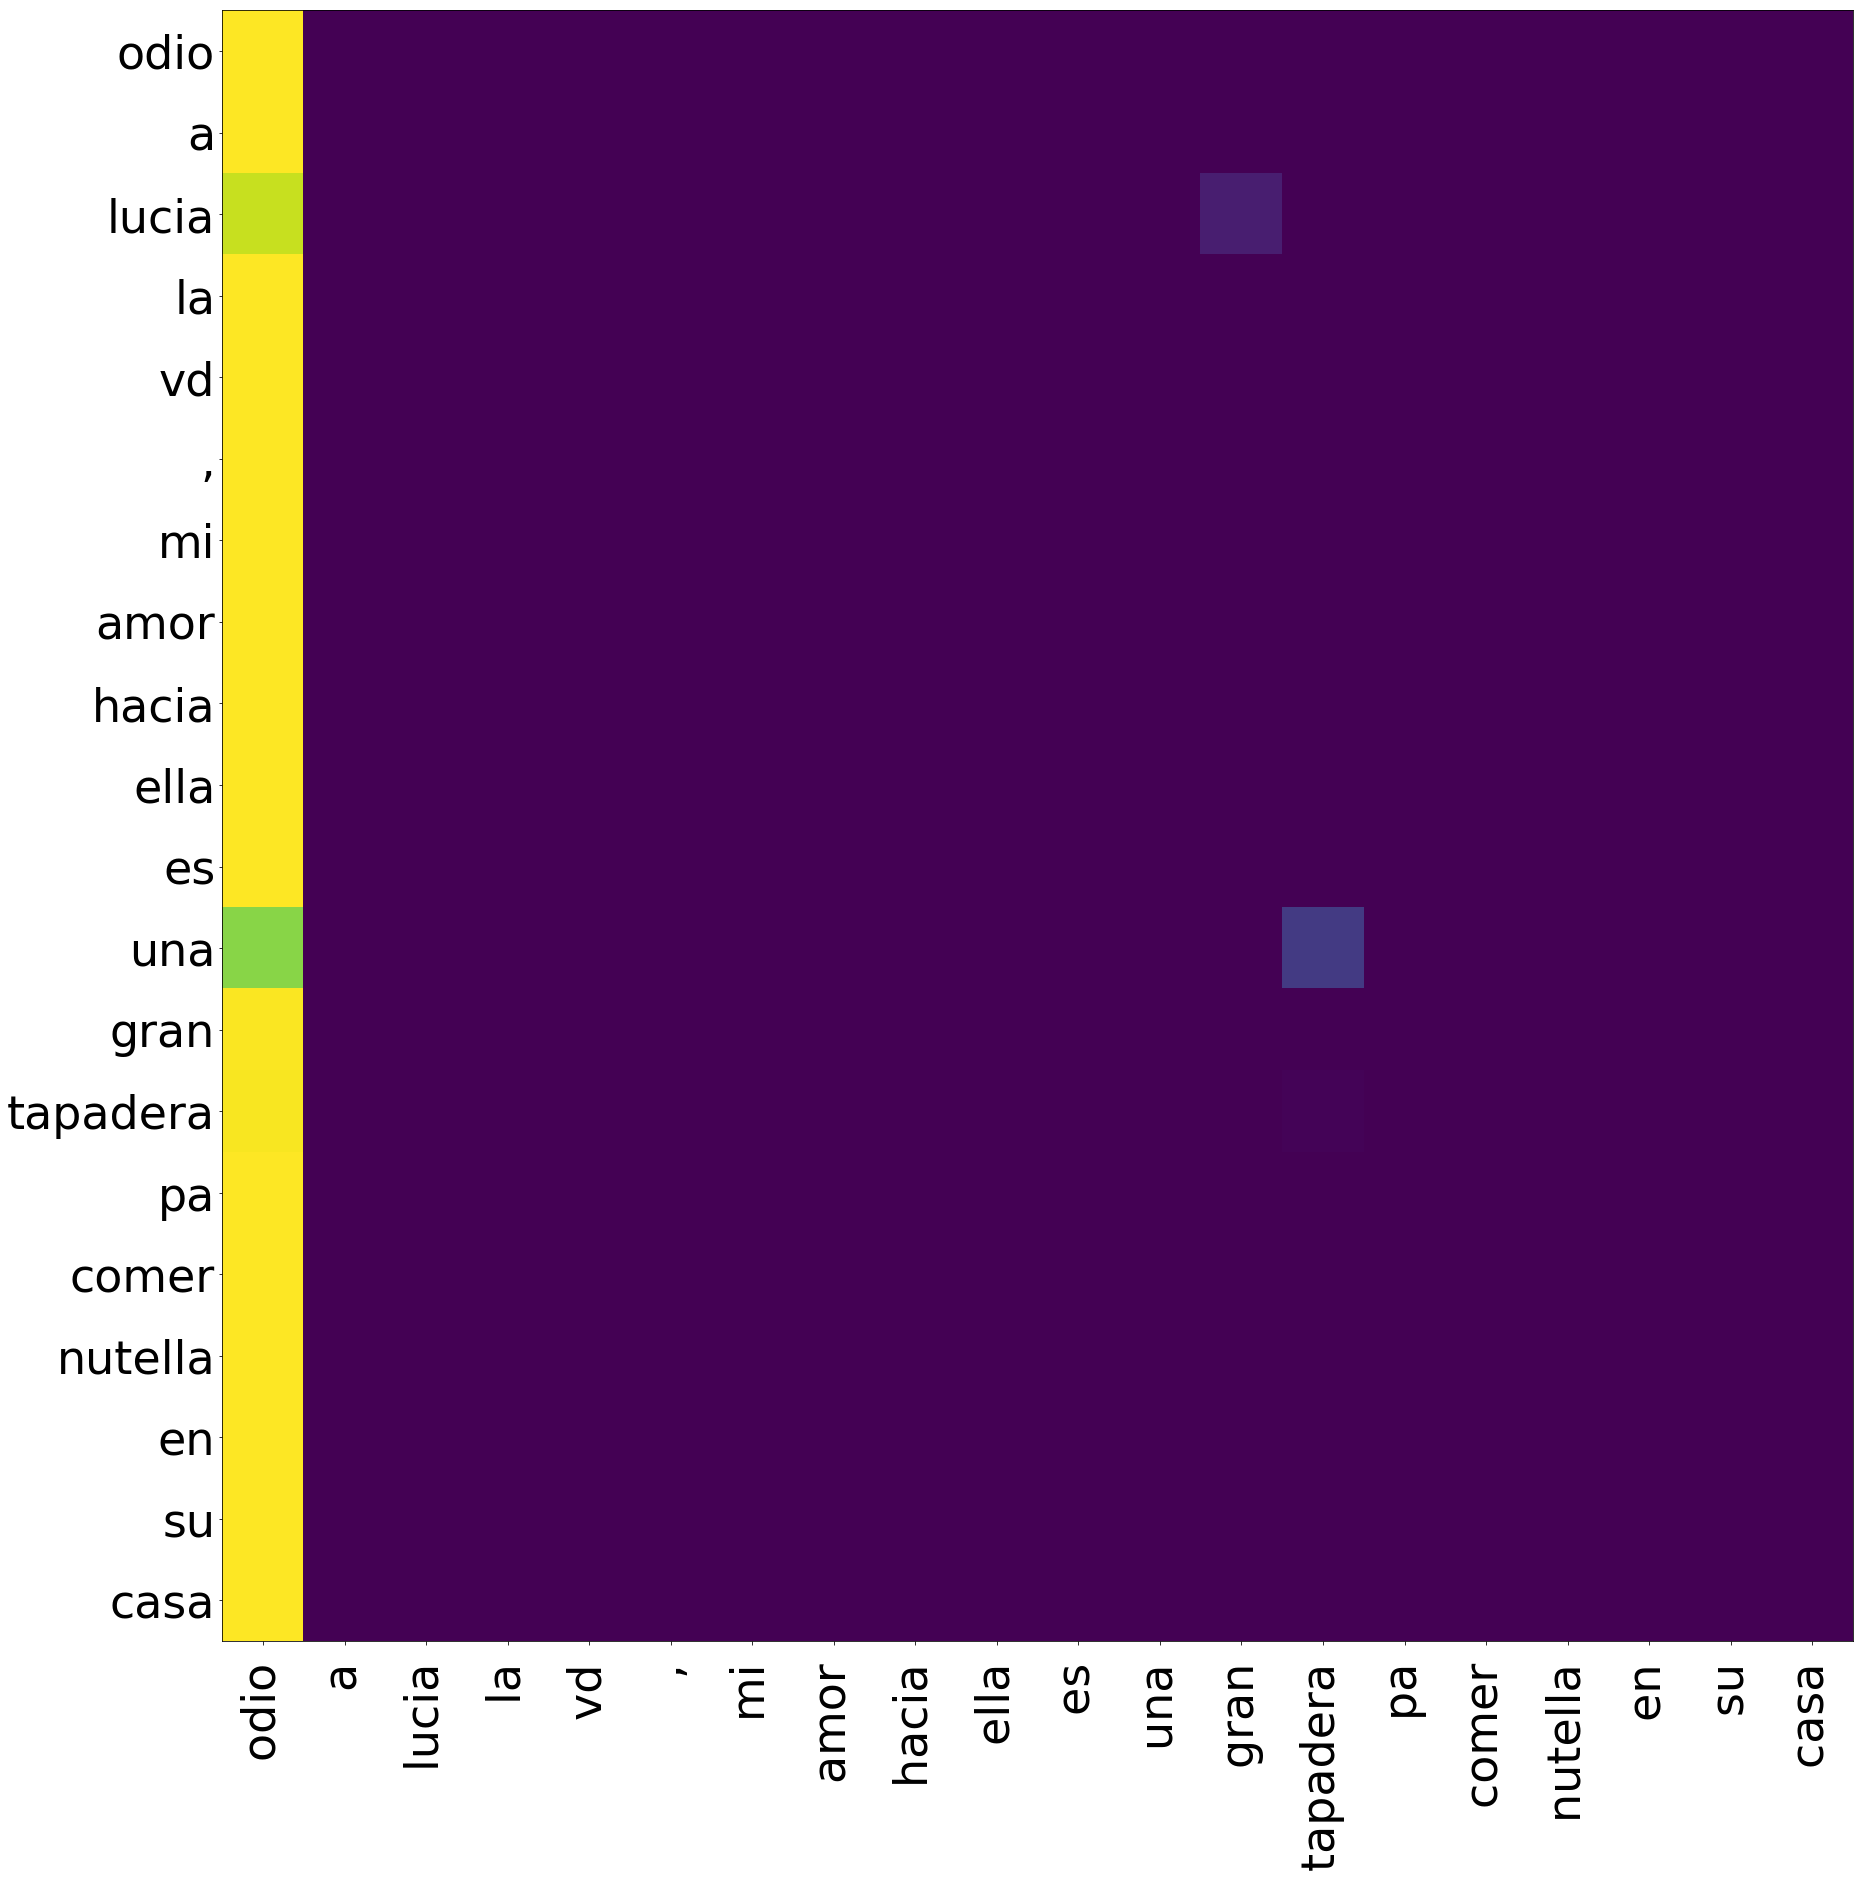

In [24]:
# Cabezal 3, parece captar negativos
Visualization.visualize_attentions(attns_h_3, 30, 30, rows=1, columns=1, ticks=l_words, output_file=None,
                                   save=False)

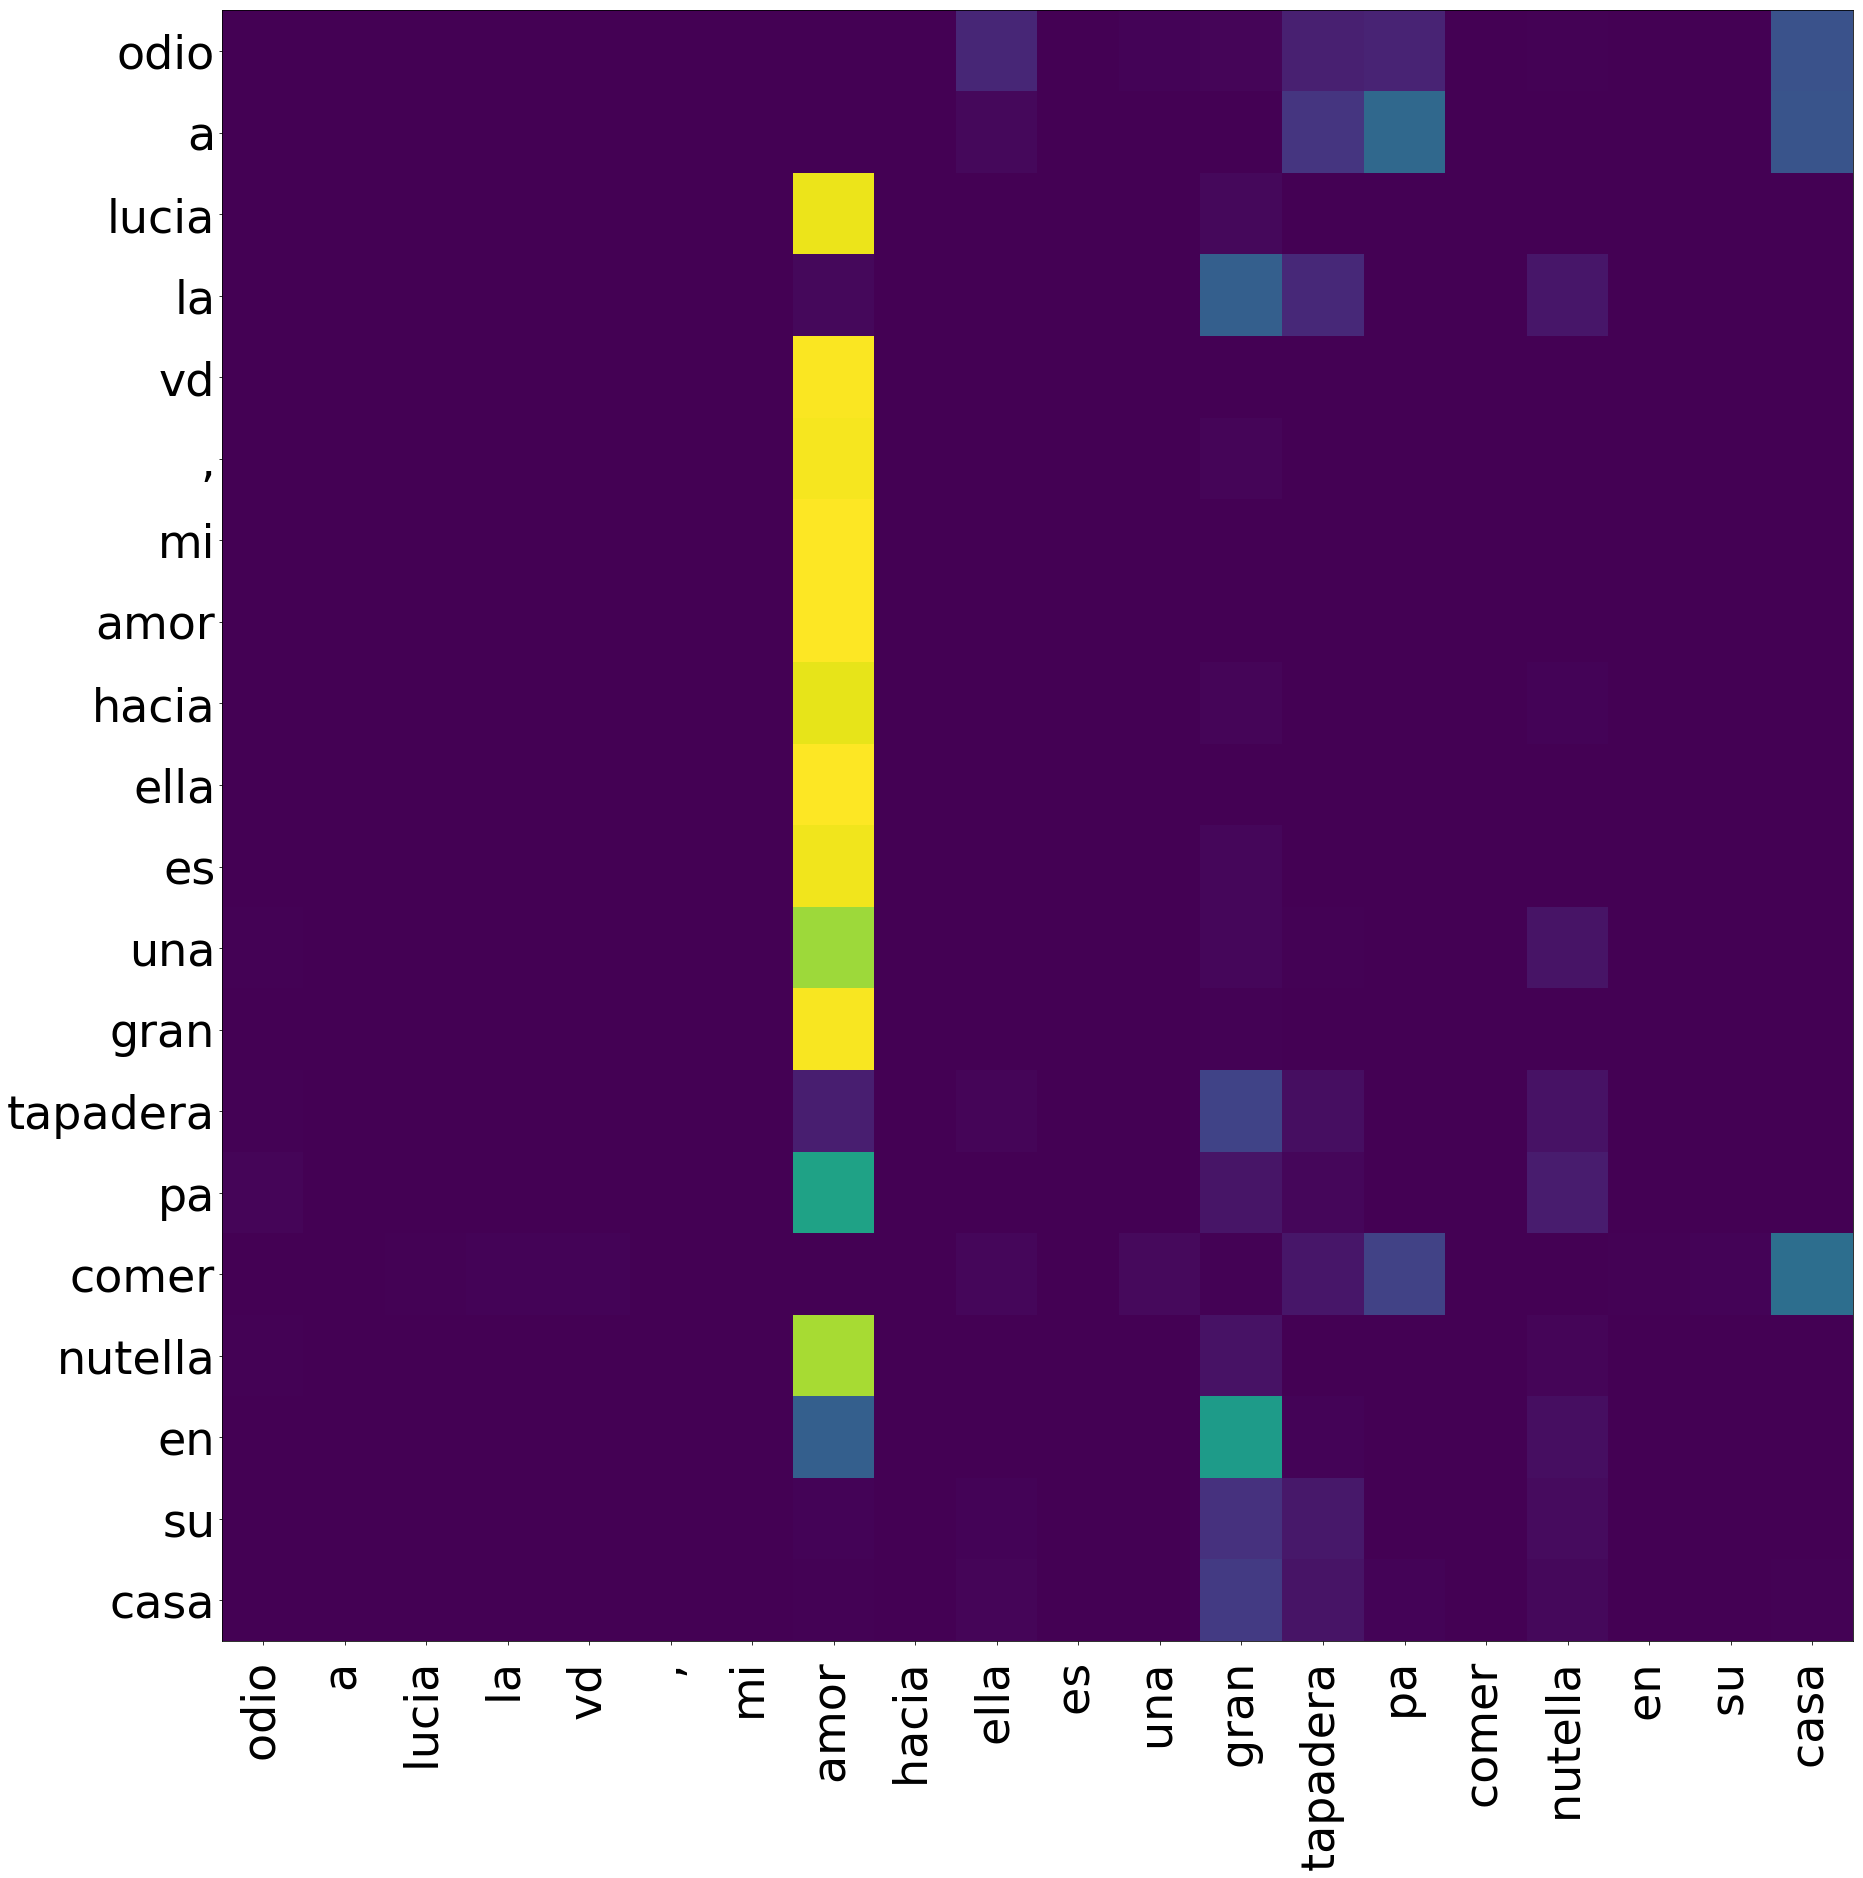

In [25]:
# Cabezal 4, parece captar positivos
Visualization.visualize_attentions(attns_h_4, 30, 30, rows=1, columns=1, ticks=l_words, output_file=None,
                                   save=False)

# Análisis con un lexicon

In [26]:
import unicodedata as uc

def remove_accents(sequence):
    return "".join([c for c in uc.normalize('NFD', sequence) if uc.category(c) != 'Mn'])

In [27]:
lex = open("./lexicons/elhuyar.txt", "r", encoding="utf8")
llex = []
for line in lex.readlines():
    s = line.strip().split("\t")
    if len(s)>1:
        word, tag = s[0], s[1]
        if "_" not in word and "-" not in word:
            word = remove_accents(word.replace("ñ", "ny"))
            llex.append((word, tag))
lex.close()

In [28]:
fw = open("attentions_elhuyar.out", "w", encoding="utf8")
for (word, tag) in llex:
    if word in word_attns:
        fw.write(word + "\n")
        for h in word_attns[word]:
            fw.write("Header %d: %.4f\n" % (h, word_attns[word][h]))
        fw.write("\n\n" + "-"*50 + "\n\n")
fw.close()

### Buscar los cabezales que maximizan su valor de atención sobre un lexicon supervisado en español (Elhuyar de ejemplo) #

In [29]:
positive_words = [word for (word, tag) in llex if tag == "positive"]
negative_words = [word for (word, tag) in llex if tag == "negative"]

In [30]:
sum_attns_positive = np.array([0. for i in range(len(word_attns["de"]))])
counts = 0.

for word in positive_words:
    if word in word_attns:
        w_attns = word_attns[word]
        h_attns = np.array([word_attns[word][h] for h in word_attns[word]])
        sum_attns_positive += h_attns
        counts += 1.
        
sum_attns_positive /= counts

<BarContainer object of 8 artists>

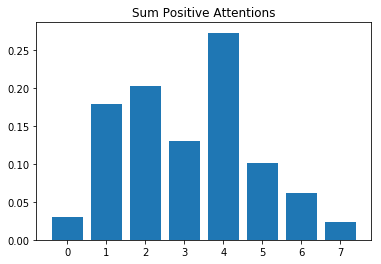

In [31]:
w = "Sum Positive Attentions"
plt.title(w)
plt.bar(list(range(8)), sum_attns_positive)

In [32]:
print("Best header positive: %d" % sum_attns_positive.argmax())

Best header positive: 4


In [33]:
sum_attns_negative = np.array([0. for i in range(len(word_attns["de"]))])
counts = 0.

for word in negative_words:
    if word in word_attns:
        w_attns = word_attns[word]
        h_attns = np.array([word_attns[word][h] for h in word_attns[word]])
        sum_attns_negative += h_attns
        counts += 1.
        
sum_attns_negative /= counts

<BarContainer object of 8 artists>

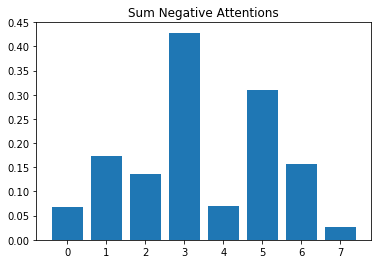

In [34]:
w = "Sum Negative Attentions"
plt.title(w)
plt.bar(list(range(8)), sum_attns_negative)

In [35]:
print("Best header negative: %d" % sum_attns_negative.argmax())

Best header negative: 3


### Clasificar el lexicon usando los cabezales 3 y 4 (75% Acc)

In [36]:
n_errors = 0.
n_words = 0.

for (word, tag) in llex:
    if word in word_attns:
        heads = word_attns[word]
        if heads[3] > heads[4]:
            pred = "negative"
        else:
            pred = "positive"
        
        if pred != tag:
            n_errors += 1
            
        n_words += 1.
        
print("Acc: %.4f%%" % ((1. - ((n_errors / n_words))) * 100))

Acc: 74.7573%


# Buscar cabezales que encuentren la negación

<BarContainer object of 8 artists>

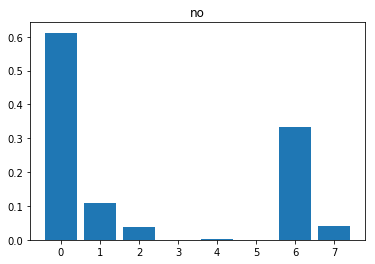

In [37]:
w = "no"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

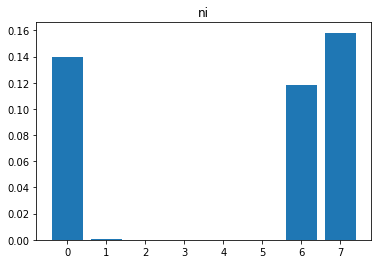

In [38]:
w = "ni"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

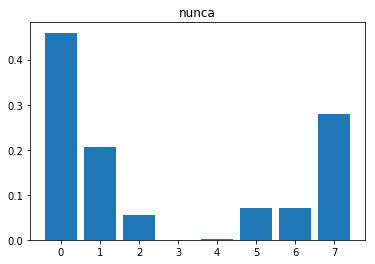

In [39]:
w = "nunca"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

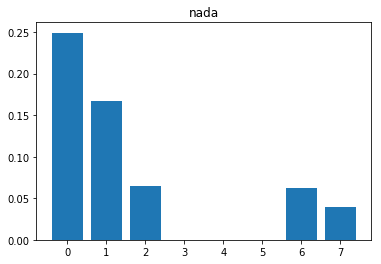

In [40]:
w = "nada"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

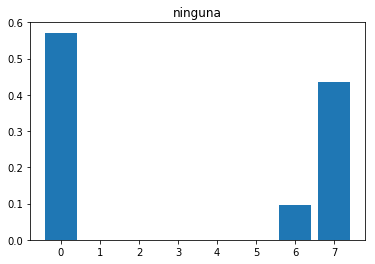

In [41]:
w = "ninguna"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

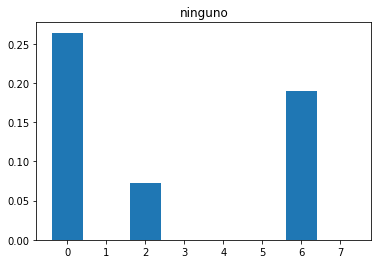

In [42]:
w = "ninguno"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

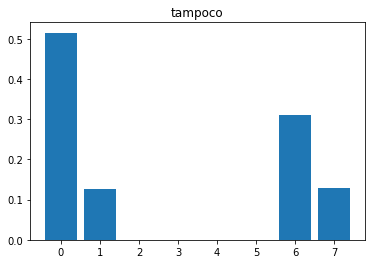

In [43]:
w = "tampoco"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

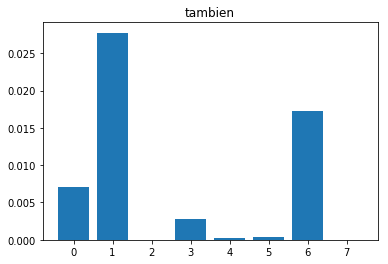

In [49]:
w = "tambien"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

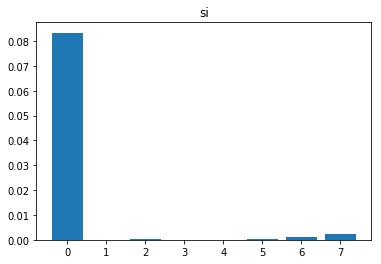

In [50]:
w = "si"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

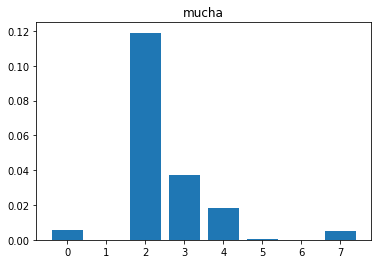

In [48]:
w = "mucha"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

El cabezal 0 reacciona a la negación, además los cabezales 3 y 4 relacionados con la polaridad tienen valor 0.
Aun así, los valores de atención no son muy elevados, i.e. el cabezal 0 sirve para más cosas - ver las palabras que maximizan la atención de cada cabezal

# Ver las palabras que maximizan la atención de cada cabezal

In [44]:
headers = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

In [45]:
for word in word_attns.keys():
    for h in headers:
        headers[h].append((word, word_attns[word][h]))
        
for h in headers:
    headers[h].sort(key=lambda tup: tup[1], reverse=True)

In [683]:
headers[0]

[('xq', 0.9999144554138184),
 ('siemprw', 0.9992435455322266),
 ('k', 0.9937522594745343),
 ('cortaste', 0.981290340423584),
 ('mal', 0.9546548789028302),
 ('cheto', 0.9365130337801847),
 ('bien', 0.8971196052141314),
 ('ardido', 0.889198805156507),
 ('kk', 0.8616903168814523),
 ('tantos', 0.8576201438903809),
 ('rara', 0.8471055636330256),
 ('mareada', 0.8451118469238281),
 ('pepino', 0.8407421906789144),
 ('lau', 0.8260722160339355),
 ('siempre', 0.805143352545701),
 ('intimidas', 0.7958546161651612),
 ('dani', 0.7945583888462612),
 ('clarito', 0.7853520711263021),
 ('fatal', 0.7784111417573074),
 ('cuando', 0.775579869873323),
 ('viejos', 0.7387549788863571),
 ('sii', 0.7366402365944602),
 ('idiota', 0.7309819134798917),
 ('algun', 0.7226852439402397),
 ('lameculos', 0.7131201267242432),
 ('llevales', 0.7038974761962891),
 ('x', 0.6984999127447223),
 ('perverso', 0.6809136390686035),
 ('q', 0.6746455186135849),
 ('traemelos', 0.6530046463012695),
 ('ahors', 0.6382555807790449),
 ('t